In [1]:
%matplotlib inline

import numpy as np
import skimage.io
import matplotlib.pyplot as plt

import keras.backend
import keras.callbacks
import keras.layers
import keras.models
import keras.optimizers

import helper.loss_functions

import tensorflow as tf

import functools

Using TensorFlow backend.


In [2]:
# set up config for GPU
configuration = tf.ConfigProto()
configuration.gpu_options.allow_growth = True
configuration.gpu_options.visible_device_list = "2"
session = tf.Session(config = configuration)

# apply session
keras.backend.set_session(session)

/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:4: DeprecationWarning: PyUnicode_AsEncodedObject() is deprecated; use PyUnicode_AsEncodedString() to encode from str to bytes or PyCodec_Encode() for generic encoding


In [3]:
dim1 = 64
dim2 = 64

batch_size = 100
epochs = 1000

path_x = '../images/X.npy'
path_y = '../images/Y.npy'

tb_log_dir = '../logs/'

In [4]:
x = keras.layers.Input((dim1, dim2, 1))

options_conv = {"activation": "relu", "kernel_size": (5, 5), "padding": "same"}
options_max_pool = {"pool_size" : (2,2), "strides" : (2,2)}

y = keras.layers.BatchNormalization()(x)

y = keras.layers.Conv2D(16, **options_conv)(y)
y = keras.layers.MaxPool2D(**options_max_pool)(y)
y = keras.layers.BatchNormalization()(y)

y = keras.layers.Conv2D(32, **options_conv)(y)
y = keras.layers.MaxPool2D(**options_max_pool)(y)
y = keras.layers.BatchNormalization()(y)

y = keras.layers.Conv2D(64, **options_conv)(y)
y = keras.layers.MaxPool2D(**options_max_pool)(y)
y = keras.layers.BatchNormalization()(y)

y = keras.layers.Conv2D(64, **options_conv)(y)

y = keras.layers.UpSampling2D()(y)
y = keras.layers.BatchNormalization()(y)
y = keras.layers.Conv2D(32, **options_conv)(y)

y = keras.layers.UpSampling2D()(y)
y = keras.layers.BatchNormalization()(y)
y = keras.layers.Conv2D(16, **options_conv)(y)

y = keras.layers.UpSampling2D()(y)
y = keras.layers.BatchNormalization()(y)
y = keras.layers.Conv2D(8, **options_conv)(y)

y = keras.layers.Conv2D(3, **options_conv)(y)

y = keras.layers.Activation('softmax')(y)

model = keras.models.Model(x, y)

In [5]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 1)         4         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 16)        416       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 16)        64        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        12832     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
__________

In [6]:
X = np.load(path_x)
Y = np.load(path_y)

# print shapes to debug
print(X.shape)
print(Y.shape)

(100, 64, 64, 1)
(100, 64, 64, 5)


In [7]:
optimizer = keras.optimizers.sgd(lr = 1e-4)
loss_wrapper = functools.partial(helper.loss_functions.crazyloss_one_thresh, dim1=64, dim2=64)
loss_wrapper.__name__ = "wrapper"
loss = loss_wrapper
callbacks = [keras.callbacks.TensorBoard(tb_log_dir, histogram_freq=10)]
model.compile(optimizer, loss)

In [8]:
model.fit(X[0:80,:,:,:], Y[0:80,:,:,:], batch_size, epochs, validation_data=(X[80:100],Y[80:100]), callbacks=callbacks)

Train on 80 samples, validate on 20 samples
INFO:tensorflow:Summary name batch_normalization_1/gamma:0 is illegal; using batch_normalization_1/gamma_0 instead.
INFO:tensorflow:Summary name batch_normalization_1/beta:0 is illegal; using batch_normalization_1/beta_0 instead.
INFO:tensorflow:Summary name batch_normalization_1/moving_mean:0 is illegal; using batch_normalization_1/moving_mean_0 instead.
INFO:tensorflow:Summary name batch_normalization_1/moving_variance:0 is illegal; using batch_normalization_1/moving_variance_0 instead.
INFO:tensorflow:Summary name conv2d_1/kernel:0 is illegal; using conv2d_1/kernel_0 instead.
INFO:tensorflow:Summary name conv2d_1/bias:0 is illegal; using conv2d_1/bias_0 instead.
INFO:tensorflow:Summary name batch_normalization_2/gamma:0 is illegal; using batch_normalization_2/gamma_0 instead.
INFO:tensorflow:Summary name batch_normalization_2/beta:0 is illegal; using batch_normalization_2/beta_0 instead.
INFO:tensorflow:Summary name batch_normalization_2/m

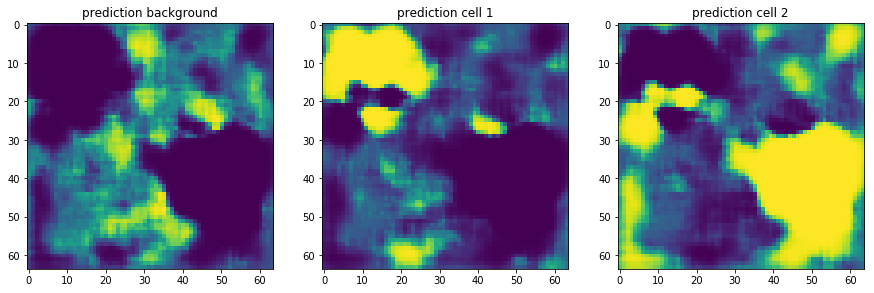

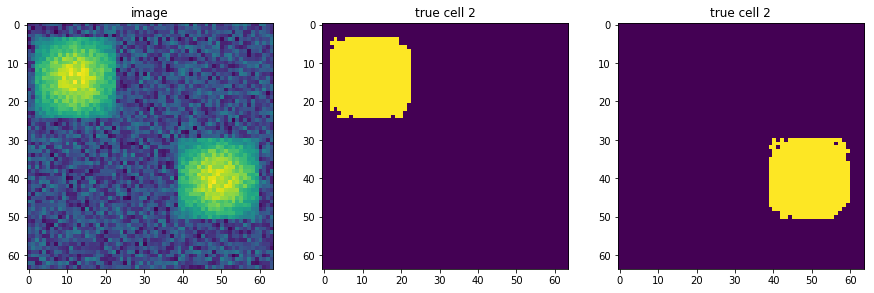

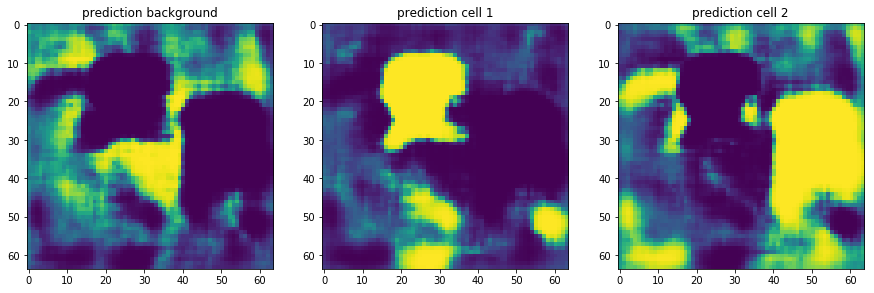

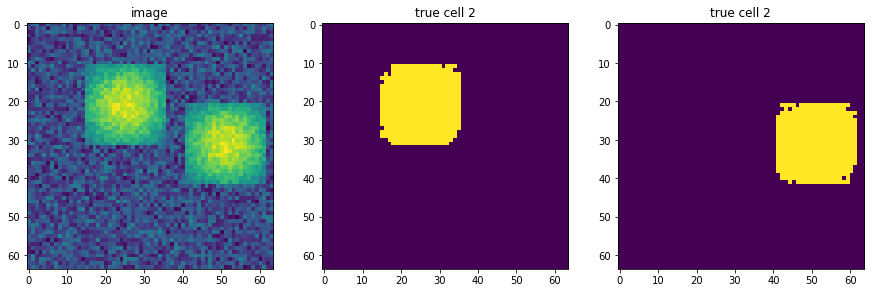

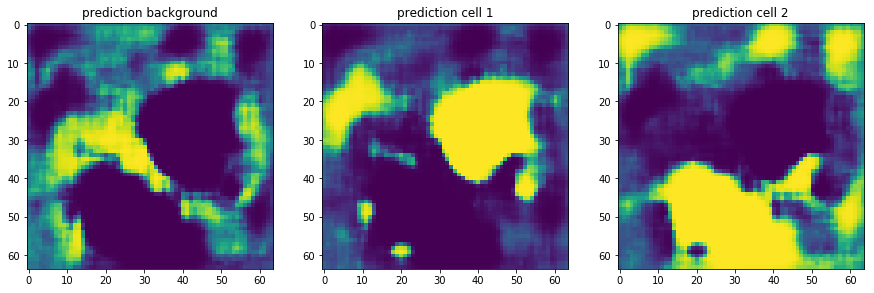

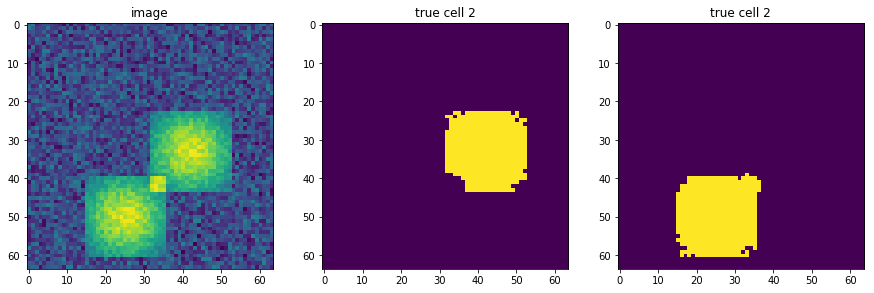

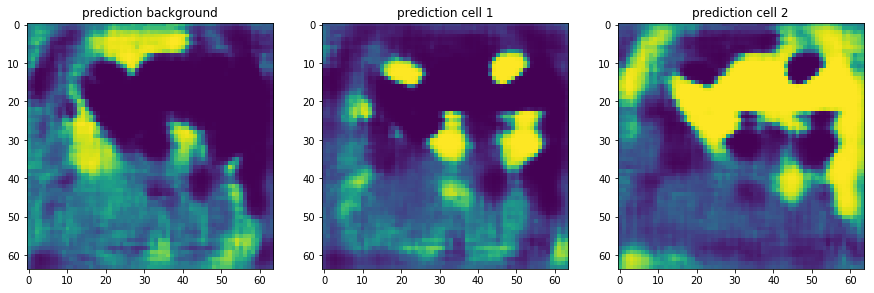

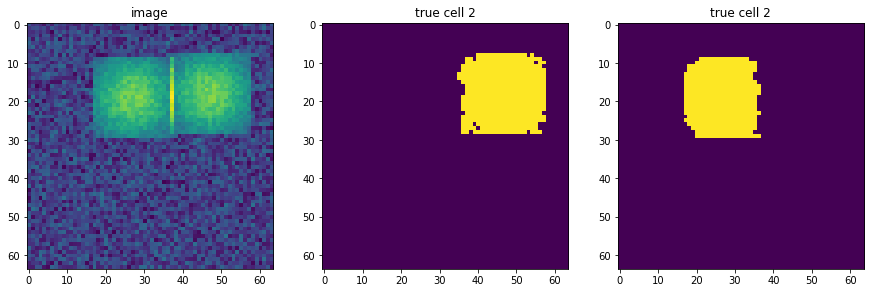

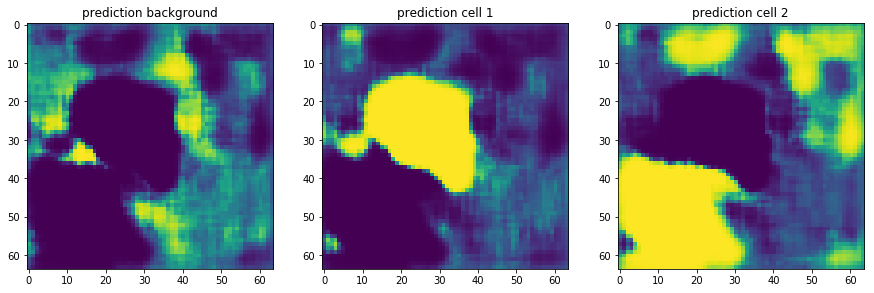

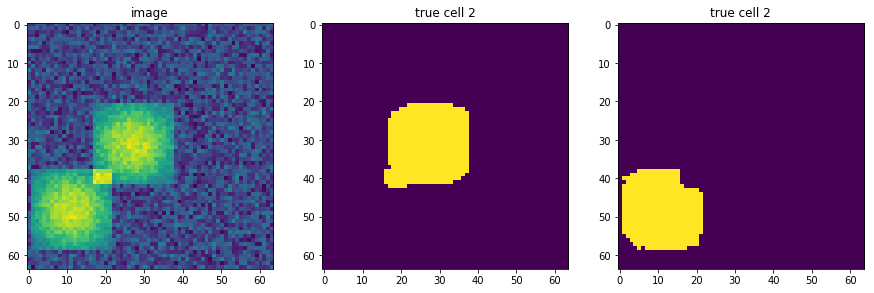

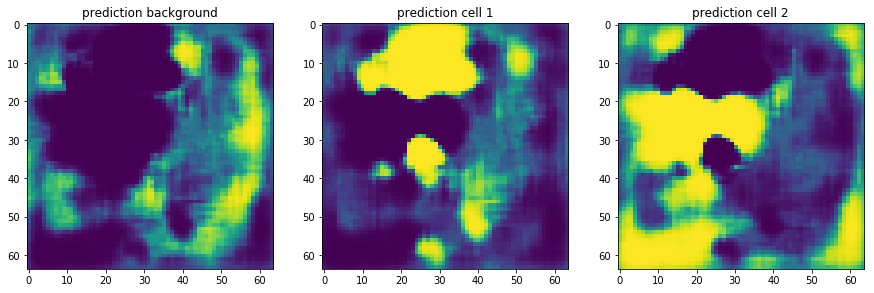

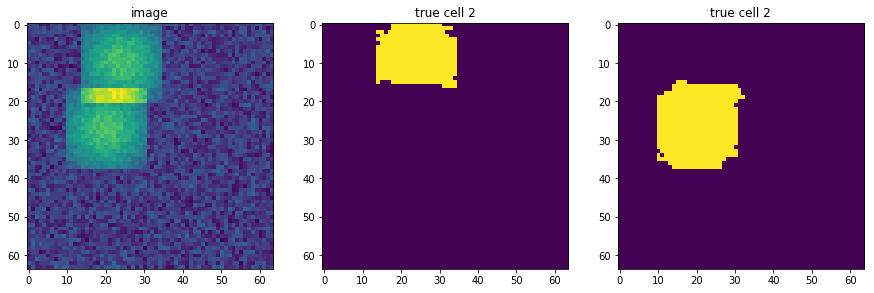

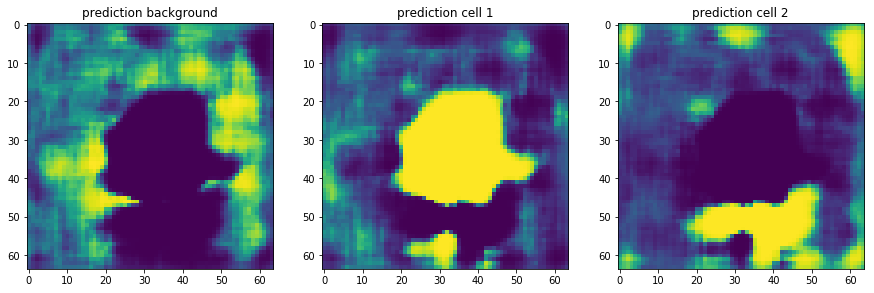

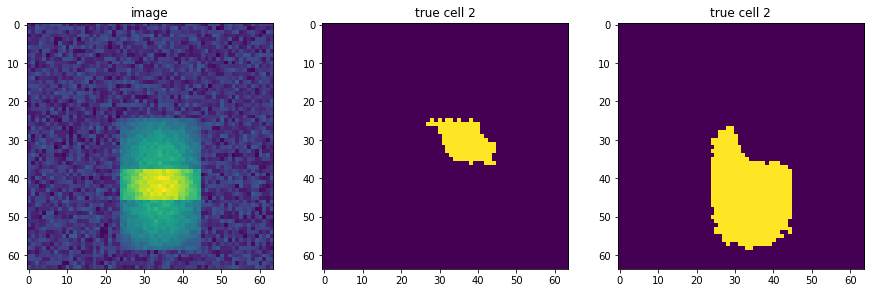

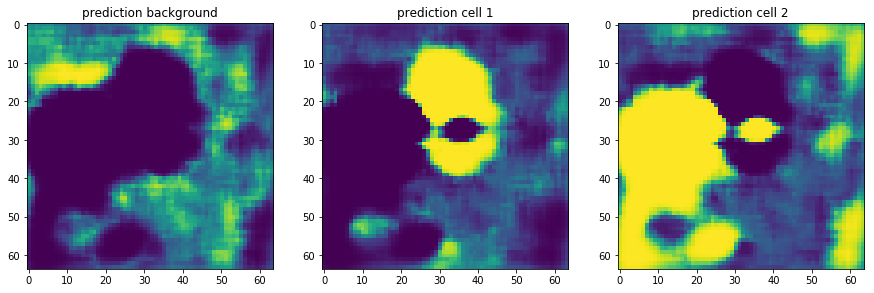

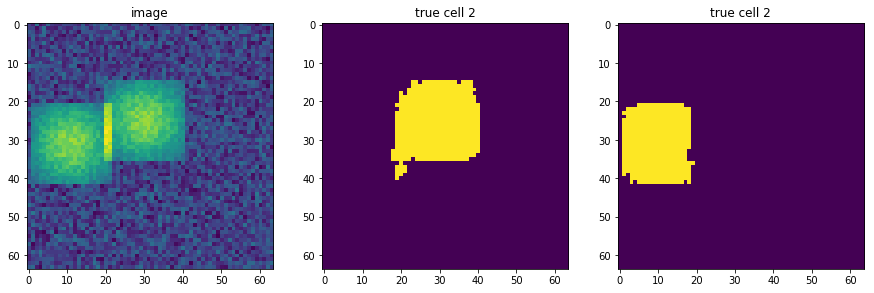

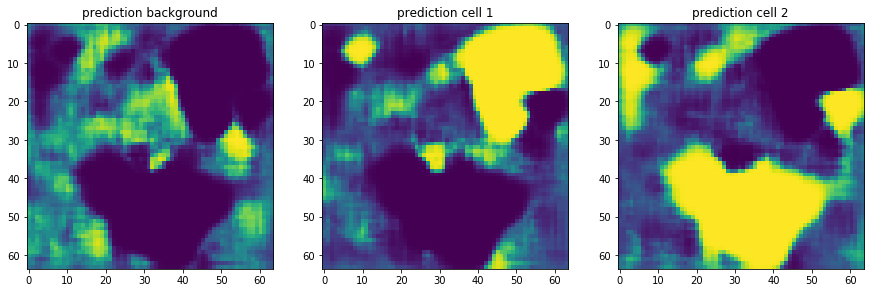

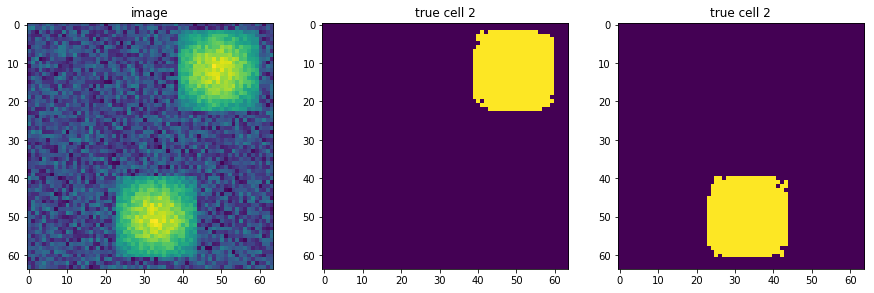

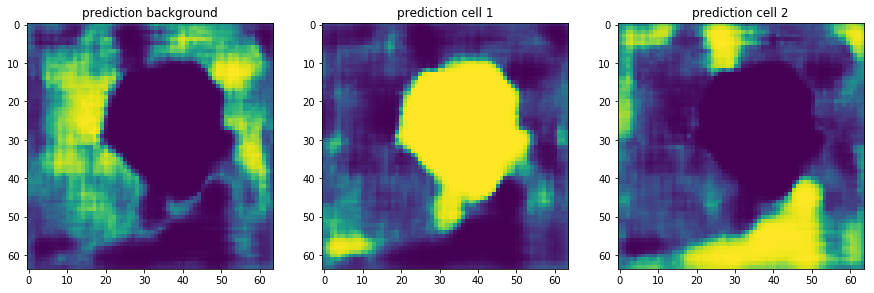

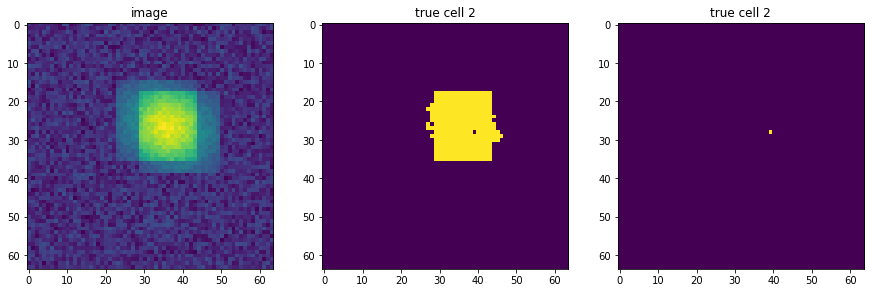

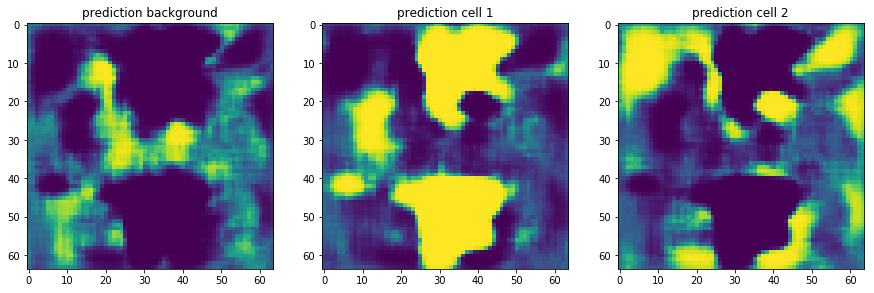

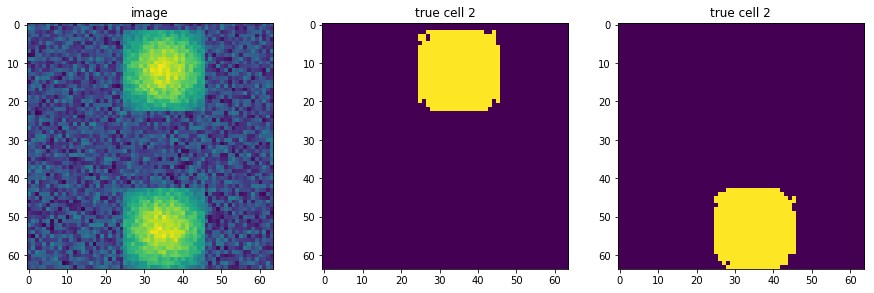

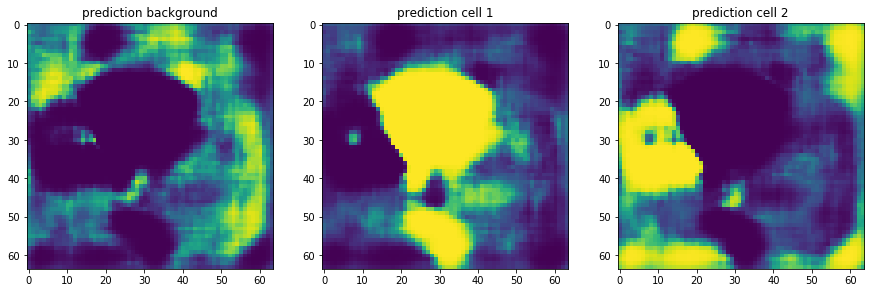

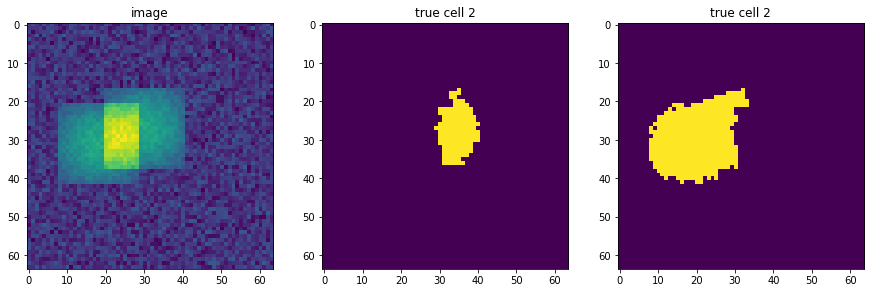

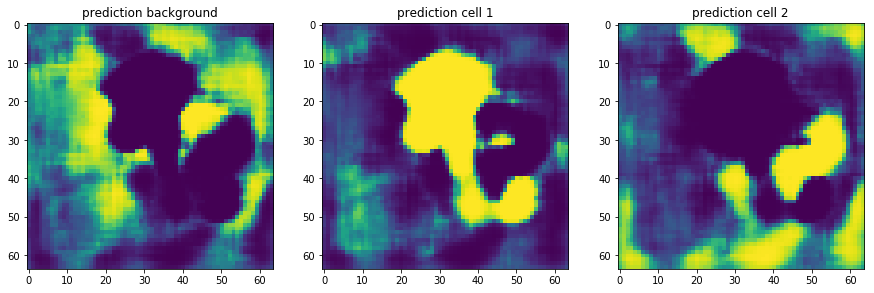

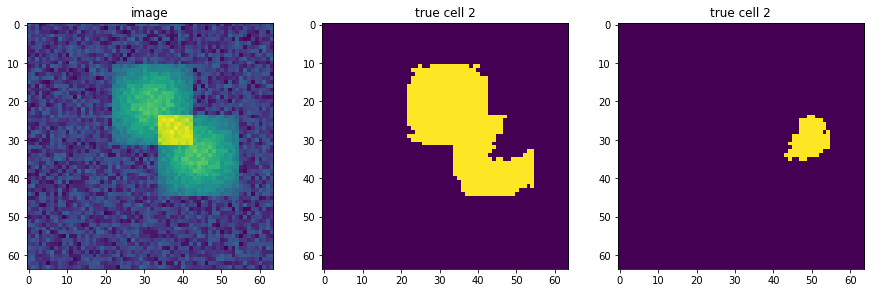

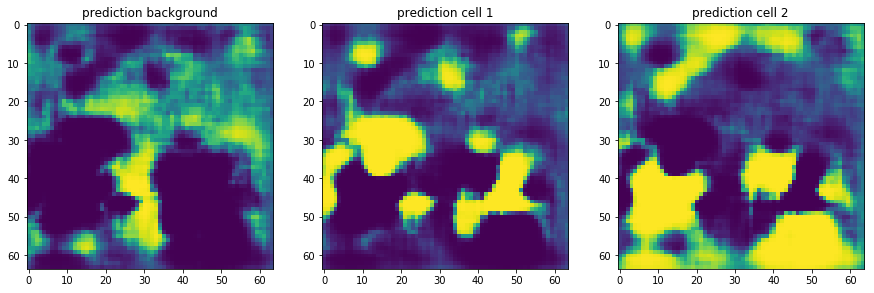

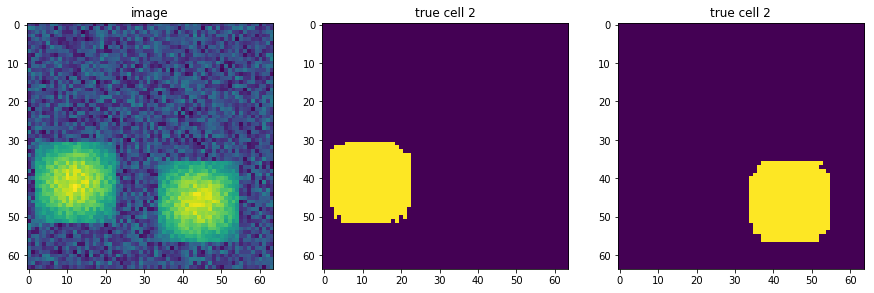

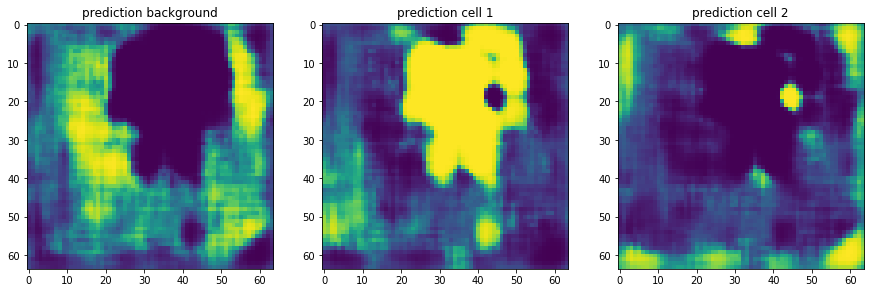

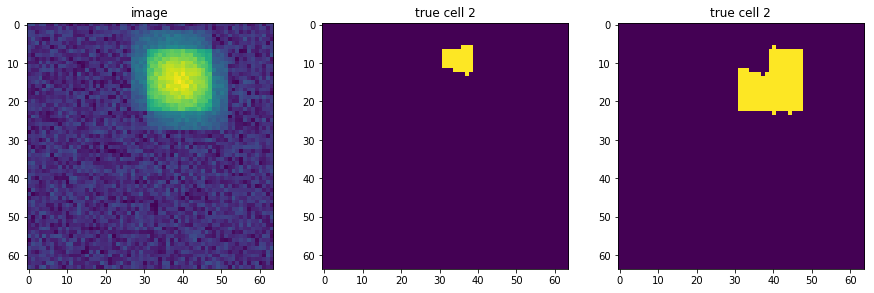

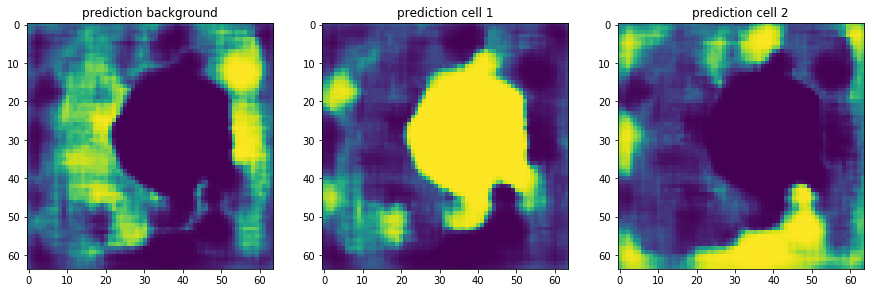

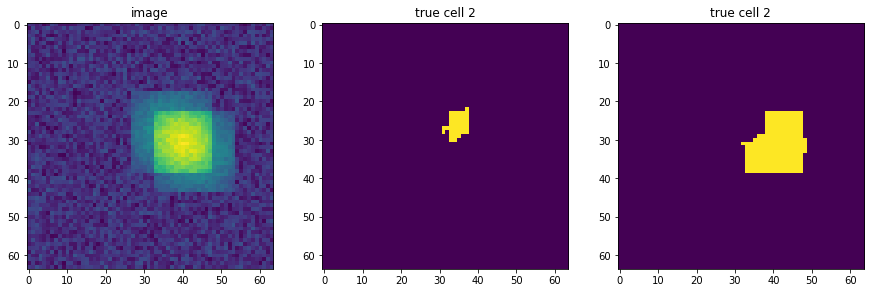

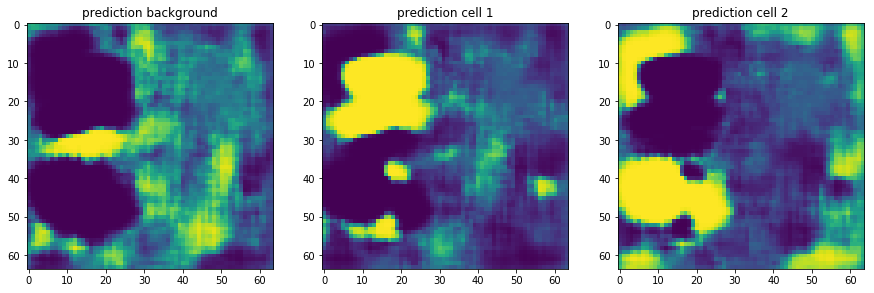

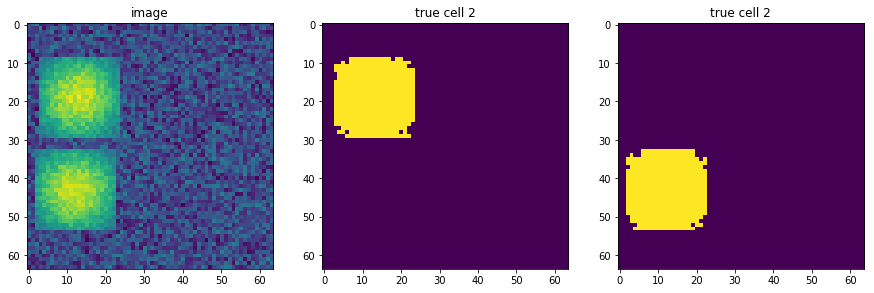

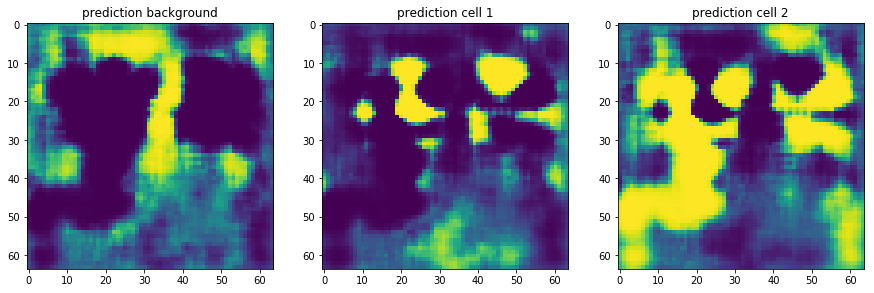

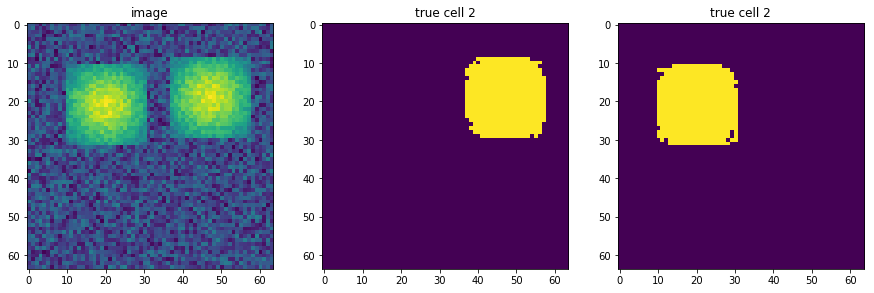

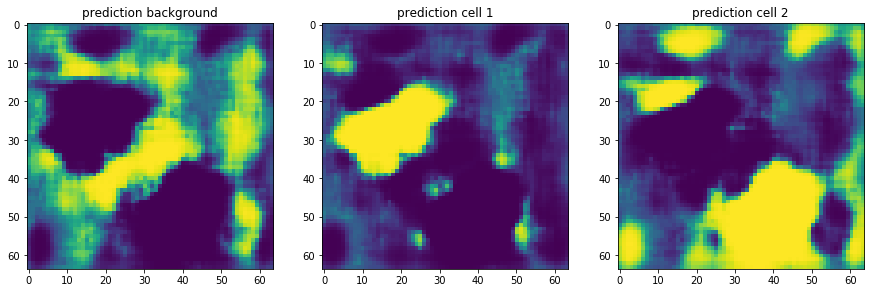

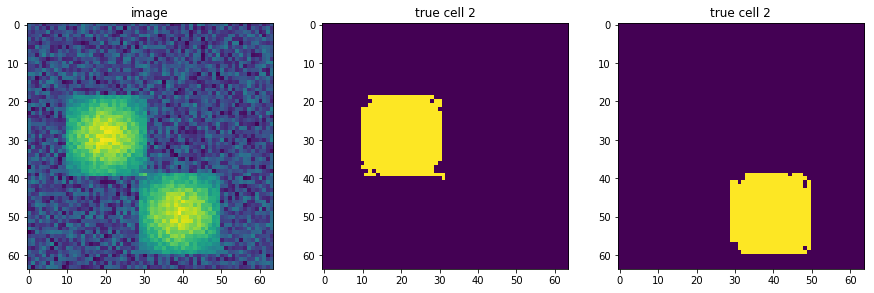

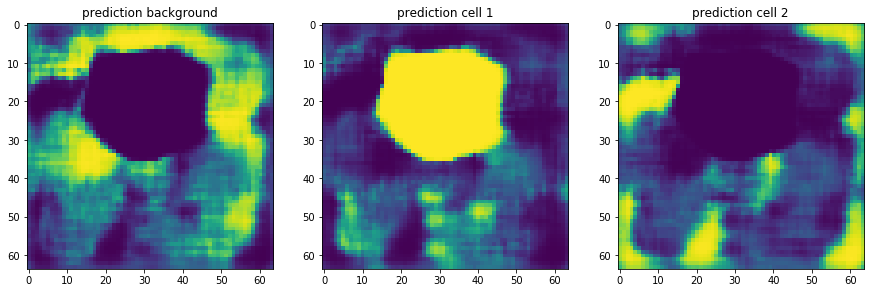

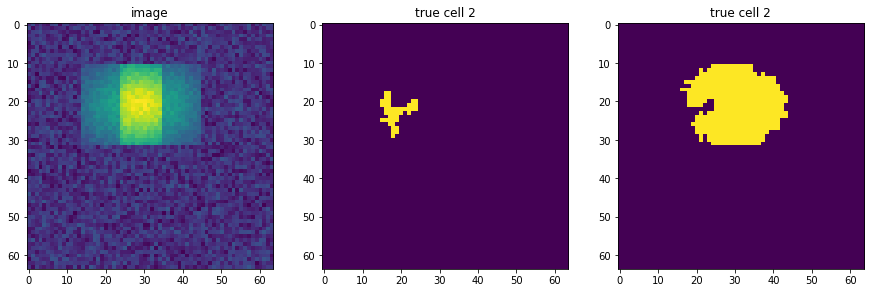

In [9]:
X_val = X[80:100]
Y_val = Y[80:100]

preds = model.predict(X_val, batch_size=batch_size)

for i in range(100-80):
    
    figure, plot = plt.subplots(ncols=3, nrows=1, figsize=(3*5, 5))
    plot[0].imshow(preds[i,:,:,0])
    plot[0].set_title('prediction background')
    plot[1].imshow(preds[i,:,:,1])
    plot[1].set_title('prediction cell 1')
    plot[2].imshow(preds[i,:,:,2])
    plot[2].set_title('prediction cell 2')
    plt.show()
    
    figure, plot = plt.subplots(ncols=3, nrows=1, figsize=(3*5, 5))
    plot[0].imshow(X_val[i,:,:,0])
    plot[0].set_title('image')
    plot[1].imshow(Y_val[i,:,:,1])
    plot[1].set_title('true cell 2')
    plot[2].imshow(Y_val[i,:,:,2])
    plot[2].set_title('true cell 2')

    plt.show()

In [10]:
# LOSS FUNCTION

def threshold_tensor(tensor):
    thresholded = tf.nn.softsign(tensor - 0.5)
    thresholded = thresholded * 3
    thresholded = (thresholded + 1) / 2
    return thresholded

def grow(tensor):
    conv_filter = tf.reshape(tf.constant([[0,0,0],[0,0,0],[0,0,0]], dtype=tf.float32), shape=(3, 3, 1))
    grown = tf.nn.dilation2d(tensor, conv_filter, strides=[1,1,1,1], rates=[1,1,1,1], padding='SAME')
    return grown

def clip(tensor, min_value, max_value):
    min_tensor = tf.fill(tf.shape(tensor), min_value)
    max_tensor = tf.fill(tf.shape(tensor), max_value)
    
    clipped_min = tf.maximum(tensor, min_value)
    clipped_both = tf.minimum(clipped_min, max_value)
    
    return clipped_both


(1, 5, 3, 5)


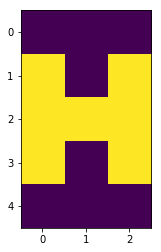

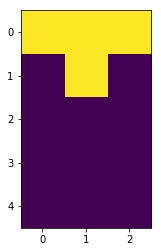

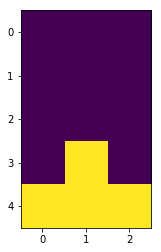

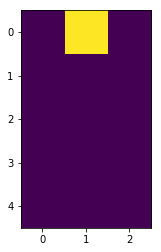

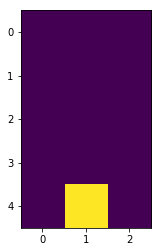

Tensor("Const_168:0", shape=(1, 5, 3, 5), dtype=float32)
Tensor("Const_167:0", shape=(1, 5, 3, 3), dtype=float32)


In [11]:
y_true_coll = np.array(
    [
        [
          [[0, 1, 0, 0, 0],
            [0, 1, 0, 1, 0],
            [0, 1, 0, 0, 0]],
           [[1, 0, 0, 0, 0],
            [0, 1, 0, 0, 0],
            [1, 0, 0, 0, 0]],
           [[1, 0, 0, 0, 0],
            [1, 0, 0, 0, 0],
            [1, 0, 0, 0, 0]],
           [[1, 0, 0, 0, 0],
            [0, 0, 1, 0, 0],
            [1, 0, 0, 0, 0]],
           [[0, 0, 1, 0, 0],
            [0, 0, 1, 0, 1],
            [0, 0, 1, 0, 0]]
        ]
    ],
    dtype=np.float32
)

print(y_true_coll.shape)
plt.imshow(y_true_coll[0,:,:,0])
plt.show()
plt.imshow(y_true_coll[0,:,:,1])
plt.show()
plt.imshow(y_true_coll[0,:,:,2])
plt.show()
plt.imshow(y_true_coll[0,:,:,3])
plt.show()
plt.imshow(y_true_coll[0,:,:,4])
plt.show()

y_pred = np.array(
    [
        [
           [[0.1, 0.8, 0.1],
            [0.1, 0.8, 0.1],
            [0.1, 0.8, 0.1]],
           [[0.8, 0.1, 0.1],
            [0.1, 0.8, 0.1],
            [0.8, 0.1, 0.1]],
           [[0.8, 0.1, 0.1],
            [0.8, 0.1, 0.1],
            [0.8, 0.1, 0.1]],
           [[0.8, 0.1, 0.1],
            [0.1, 0.1, 0.8],
            [0.8, 0.1, 0.1]],
           [[0.1, 0.1, 0.8],
            [0.1, 0.1, 0.8],
            [0.1, 0.1, 0.8]]
        ]
    ],
    dtype=np.float32
) 

pred = tf.constant(y_pred)
true = tf.constant(y_true_coll)

print(true)
print(pred)

dim1 = 5
dim2 = 3

In [12]:
def tprint(tensor):
    result = tensor.eval(session = tf.Session())
    plt.imshow(np.squeeze(result))
    plt.colorbar()
    plt.show()



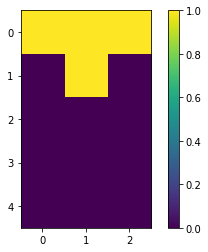

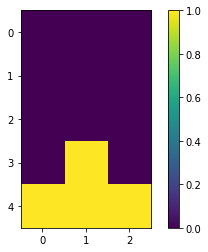

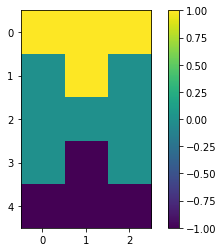

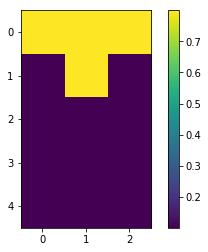

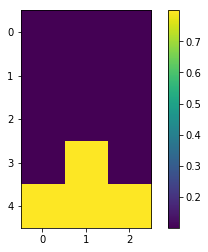

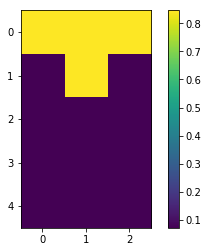

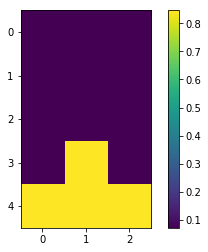

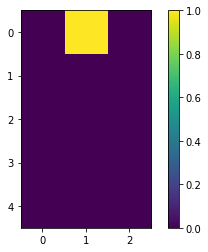

multiplied 1:


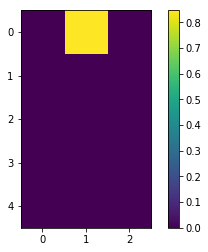

grown 1:


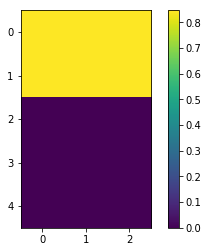

clipped 1:


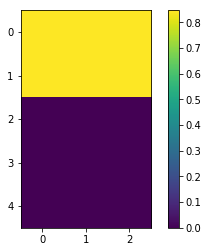

multiplied 1:


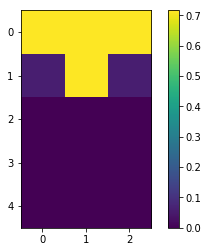

grown 1:


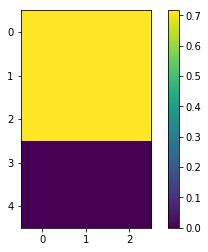

clipped 1:


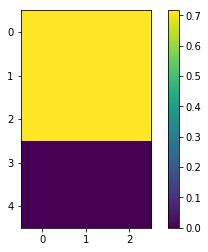

multiplied 1:


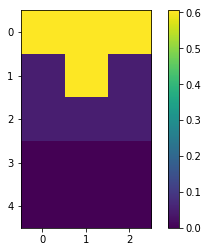

grown 1:


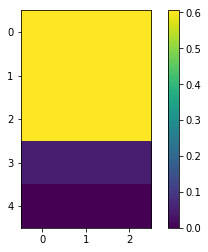

clipped 1:


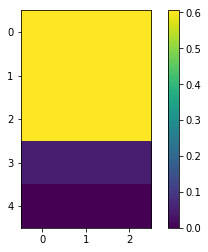

multiplied 1:


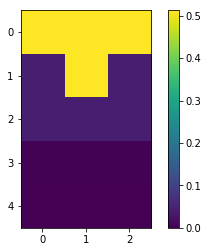

grown 1:


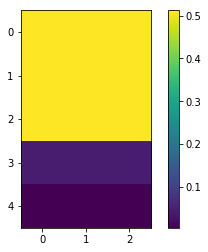

clipped 1:


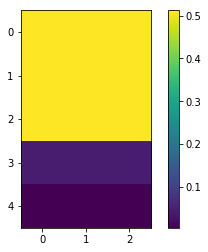

multiplied 1:


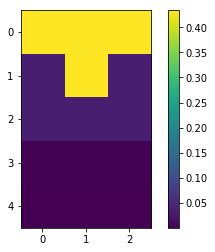

grown 1:


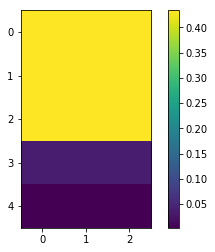

clipped 1:


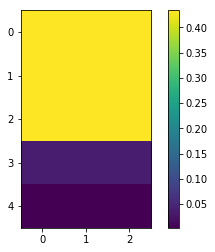

multiplied 2:


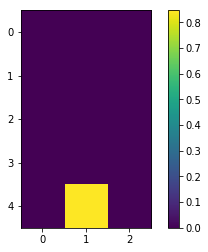

grown 2:


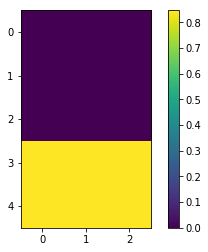

clipped 2:


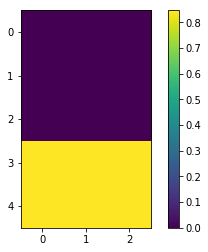

multiplied 2:


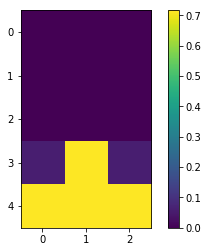

grown 2:


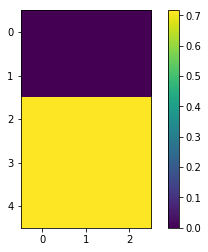

clipped 2:


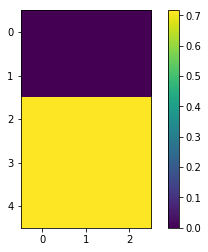

multiplied 2:


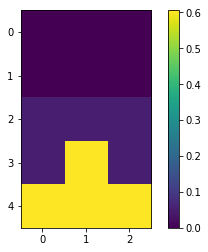

grown 2:


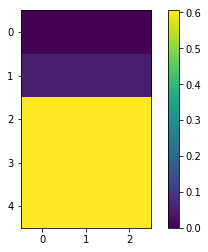

clipped 2:


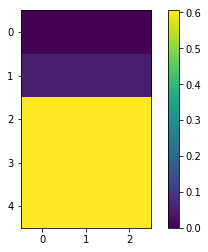

multiplied 2:


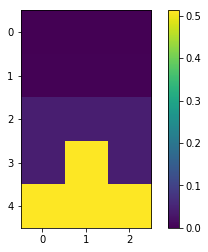

grown 2:


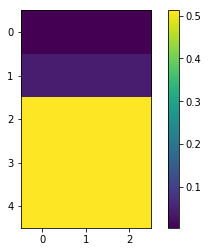

clipped 2:


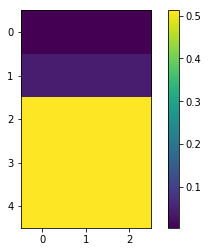

multiplied 2:


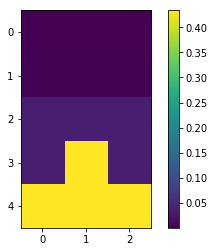

grown 2:


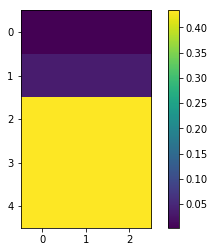

clipped 2:


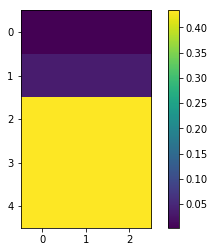

array([-3.37828016], dtype=float32)

In [13]:
slicer_img_1c_size = tf.constant([-1,dim1,dim2,1])
slicer_img_3c_size = tf.constant([-1,dim1,dim2,3])

slicer_img_begin = tf.constant([0,0,0,0])
slicer_seed1_begin = tf.constant([0,0,0,3])
slicer_seed2_begin = tf.constant([0,0,0,4])

# get image and seeds
y_true_img = tf.slice(y_true_coll, slicer_img_begin, slicer_img_3c_size)
seed1 = tf.slice(y_true_coll, slicer_seed1_begin, slicer_img_1c_size)
seed2 = tf.slice(y_true_coll, slicer_seed2_begin, slicer_img_1c_size)

# slice images in layers
slicer_img_nuc1_begin = tf.constant([0,0,0,1])
slicer_img_nuc2_begin = tf.constant([0,0,0,2])

# 1 where we have the respective nucleus in y_true
nuc1_true = tf.slice(y_true_img, slicer_img_nuc1_begin, slicer_img_1c_size)
nuc2_true = tf.slice(y_true_img, slicer_img_nuc2_begin, slicer_img_1c_size)
nucleus_masks = nuc1_true - nuc2_true

tprint(nuc1_true)
tprint(nuc2_true)
tprint(nucleus_masks)

nuc1_pred = tf.slice(y_pred, slicer_img_nuc1_begin, slicer_img_1c_size)
nuc2_pred = tf.slice(y_pred, slicer_img_nuc2_begin, slicer_img_1c_size)

nuc1_pred_thresh = threshold_tensor(nuc1_pred)
nuc2_pred_thresh = threshold_tensor(nuc2_pred)

tprint(nuc1_pred)
tprint(nuc2_pred)

tprint(nuc1_pred_thresh)
tprint(nuc2_pred_thresh)

# start with seed
region1 = tf.reshape(seed1, shape=(-1, dim1, dim2, 1))

tprint(region1)

# grow region
for i in range(np.maximum(dim1, dim2)):
    region1 = region1 * nuc1_pred_thresh
    print('multiplied 1:')
    tprint(region1)
    region1 = grow(region1)
    print('grown 1:')
    tprint(region1)
    region1 = clip(region1, 0, 1)
    print('clipped 1:')
    tprint(region1)

# start with seed
region2 = tf.reshape(seed2, shape=(-1, dim1, dim2, 1))

# grow region
for i in range(np.maximum(dim1, dim2)):
    region2 = region2 * nuc2_pred_thresh
    print('multiplied 2:')
    tprint(region2)
    region2 = grow(region2)
    print('grown 2:')
    tprint(region2)
    region2 = clip(region2, 0, 1)
    print('clipped 2:')
    tprint(region2)

loss1 = tf.reduce_mean(tf.abs(tf.reduce_sum(region1 * nucleus_masks, axis=[1,2])),axis=0)
loss2 = tf.reduce_mean(tf.abs(tf.reduce_sum(region2 * nucleus_masks, axis=[1,2])),axis=0)

loss =  - (loss1 + loss2)

loss.eval(session=tf.Session())

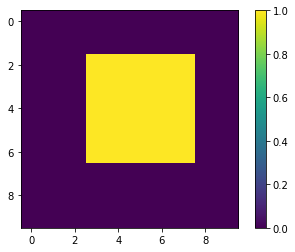

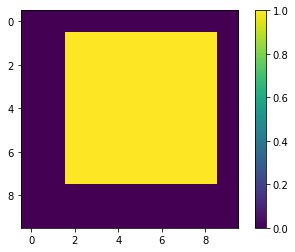

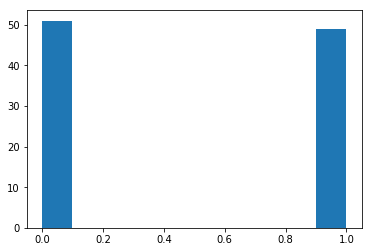

In [14]:
_in_data = np.zeros(shape=(1,10,10,1),dtype=np.float64)
_in_data[0,2:7,3:8,0] = 1
_in = tf.constant(_in_data)
conv_filter = tf.reshape(tf.constant([[0,0,0],[0,0,0],[0,0,0]], dtype=tf.float64), shape=(3, 3, 1))
_out = tf.nn.dilation2d(_in, conv_filter, strides=[1,1,1,1], rates=[1,1,1,1], padding='SAME')

result = _out.eval(session=tf.Session())

plt.imshow(_in_data[0,:,:,0])
plt.colorbar()
plt.show()

plt.imshow(result[0,:,:,0])
plt.colorbar()
plt.show()

plt.hist(result.flatten())
plt.show()

